# supernode-features

The procedure of collecting and engineering supernode features for subsequent clustering.

Warning! Calculating centralities (closeness and betweenness) for the P-space graph takes about 60 minutes.

Requires:

1. `data/supernodes/supernode_attributes.json`
2. `data/supernodes/edges_lspace.json`
3. `data/supernodes/edges_pspace.json`

Produces:
1. `data/features/infrastructure_features.json`
2. `data/features/lspace_features.json`
3. `data/features/pspace_features.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from myutils.json import load_json, save_json

from config import supernode_attributes_fpath, edges_lspace_fpath, edges_pspace_fpath, \
    infrastructure_features_fpath, lspace_features_fpath, pspace_features_fpath

In [3]:
supernode_attributes = pd.read_json(supernode_attributes_fpath).set_index('id')

supernode_attributes.head(2)

,residential_building,shop,catering_place,service,medicine,sight_place_tourism,education,company,sport,car_supply,organisation,supermarket,hotel_business,electronics_and_telecommunication,bank_and_money,printing_and_books,religion,post_office,business_center_or_mall_or_marketplace
id,,,,,,,,,,,,,,,,,,,
0,39,9,3,2,4,4,6,2,3,0,2,3,0,0,1,0,0,1,0
1,5,172,48,35,10,3,3,11,2,6,2,2,0,9,3,13,3,7,7


In [4]:
edges_lspace = [tuple(item.values()) for item in load_json(edges_lspace_fpath)]

edges_lspace[:5]

[(626, 836, 6), (836, 837, 10), (17, 837, 10), (17, 309, 12), (75, 309, 12)]

In [5]:
edges_pspace = [tuple(item.values()) for item in load_json(edges_pspace_fpath)]

edges_pspace[:5]

[(626, 836, 0.44657616594606997),
 (626, 837, 0.9102138231959868),
 (17, 626, 1.1097232146063742),
 (309, 626, 1.5763256068546179),
 (75, 626, 1.9253778263958403)]

## Infrastructure features

In [6]:
infrastructure_features = supernode_attributes.copy()

total = infrastructure_features.sum(axis=1)
infrastructure_features = infrastructure_features.divide(total, axis=0)
infrastructure_features['total'] = total

infrastructure_features.head(2)

,residential_building,shop,catering_place,service,medicine,sight_place_tourism,education,company,sport,car_supply,organisation,supermarket,hotel_business,electronics_and_telecommunication,bank_and_money,printing_and_books,religion,post_office,business_center_or_mall_or_marketplace,total
id,,,,,,,,,,,,,,,,,,,,
0,0.493671,0.113924,0.037975,0.025316,0.050633,0.050633,0.075949,0.025316,0.037975,0.000000,0.025316,0.037975,0.0,0.000000,0.012658,0.000000,0.000000,0.012658,0.000000,79
1,0.014663,0.504399,0.140762,0.102639,0.029326,0.008798,0.008798,0.032258,0.005865,0.017595,0.005865,0.005865,0.0,0.026393,0.008798,0.038123,0.008798,0.020528,0.020528,341


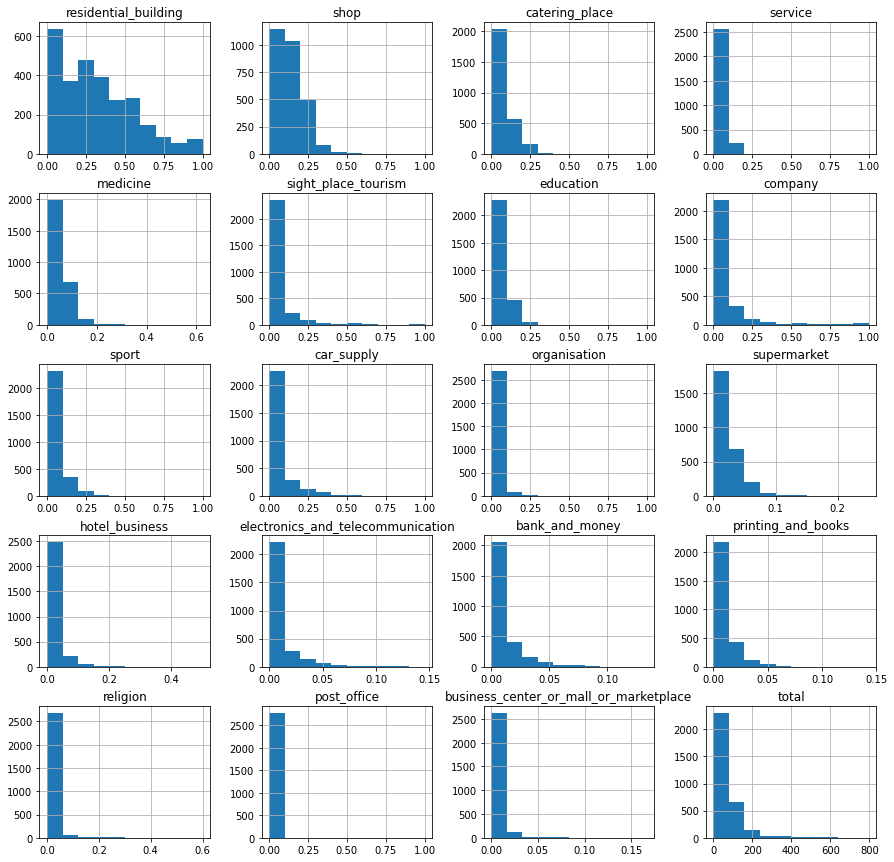

In [7]:
infrastructure_features.hist(figsize=(15, 15));

<AxesSubplot:>

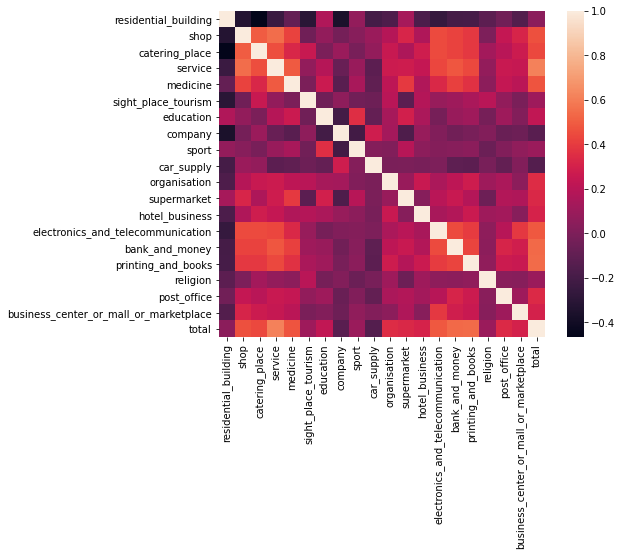

In [8]:
plt.figure(figsize=(8, 6))

sns.heatmap(infrastructure_features.corr(method='spearman'), square=True)

In [9]:
infrastructure_features_json = []

for _, row in infrastructure_features.reset_index().iterrows():
    row = row.to_dict()
    row['id'] = int(row['id'])
    infrastructure_features_json.append(row)

In [10]:
save_json(infrastructure_features_json, infrastructure_features_fpath)

## Graph features

In [11]:
def construct_graph_features(g: nx.Graph) -> pd.DataFrame:
    neighbours = {node: set(g.neighbors(node)) for node in g.nodes}
    neighbours_2hop = {node: set.union(*[neighbours[n] for n in neighbours[node]]) for node in g.nodes}
    
    degree = pd.Series(dict(nx.degree(g, weight='weight')))
    clustering = pd.Series(nx.clustering(g, weight=None))
    closeness_centrality = pd.Series(nx.closeness_centrality(g, distance='distance'))
    betweenness_centrality = pd.Series(nx.betweenness_centrality(g, weight='distance'))
    
    features = {
        'degree': degree,
        'clustering': clustering,
        'cl_centr': closeness_centrality,
        'betw_centr': betweenness_centrality,
    }
    
    neighbourhood_features = {}
    
    for name, values in features.items():
        values_1hop_mean = pd.Series({
            node: values.loc[neighbours[node]].mean()
            for node in g.nodes
        })
        values_2hop_mean = pd.Series({
            node: values.loc[neighbours_2hop[node]].mean()
            for node in g.nodes
        })
        
        neighbourhood_features[name + '_1hop_mean'] = values_1hop_mean
        neighbourhood_features[name + '_2hop_mean'] = values_2hop_mean
        
    features.update(neighbourhood_features)
    features = pd.DataFrame(features).sort_index(axis=1)
    
    return features

### L-space features

In [12]:
lspace = nx.Graph()
lspace.add_weighted_edges_from(edges_lspace)

nx.set_edge_attributes(
    lspace,
    values=(1 / pd.Series(nx.get_edge_attributes(lspace, 'weight'))).to_dict(),
    name='distance',
)

len(lspace), len(lspace.edges)

(3226, 5352)

In [13]:
%%time

lspace_features = construct_graph_features(lspace)

lspace_features.head(2)

CPU times: user 1min 12s, sys: 108 ms, total: 1min 12s
Wall time: 1min 12s


,betw_centr,betw_centr_1hop_mean,betw_centr_2hop_mean,cl_centr,cl_centr_1hop_mean,cl_centr_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,degree,degree_1hop_mean,degree_2hop_mean
626,3.986093e-04,0.093540,0.054850,0.387833,0.390149,0.377443,0.666667,0.358730,0.192269,24,54.333333,38.444444
836,5.770673e-07,0.000544,0.056413,0.364450,0.384264,0.387654,0.333333,0.444444,0.348571,20,27.333333,43.800000


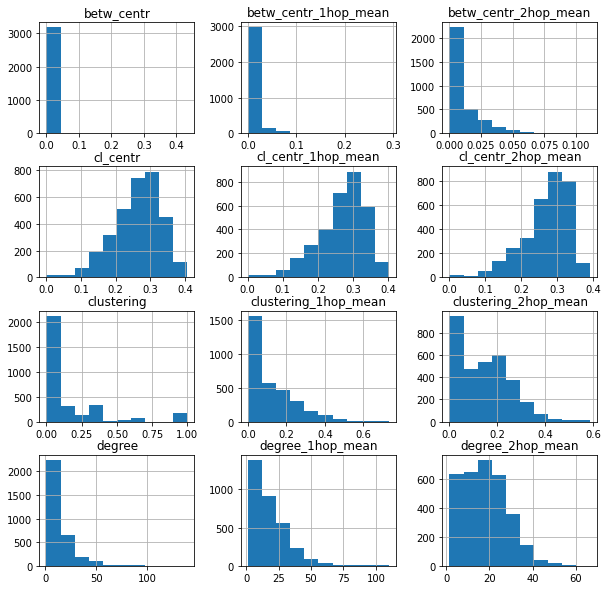

In [14]:
lspace_features.hist(figsize=(10, 10));

<AxesSubplot:>

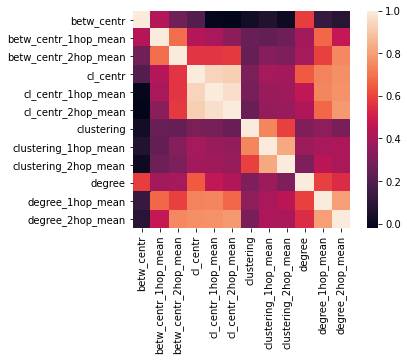

In [15]:
sns.heatmap(lspace_features.corr(method='spearman'), square=True)

In [16]:
lspace_features_json = []

for i, row in lspace_features.sort_index().iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    lspace_features_json.append(item)
    
lspace_features_json[0]

{'id': 0,
 'betw_centr': 0.008443072306538173,
 'betw_centr_1hop_mean': 0.004128623939201584,
 'betw_centr_2hop_mean': 0.019366442636300104,
 'cl_centr': 0.3503245290354669,
 'cl_centr_1hop_mean': 0.3283510582958426,
 'cl_centr_2hop_mean': 0.3321362812458911,
 'clustering': 0.12727272727272726,
 'clustering_1hop_mean': 0.2963570026811133,
 'clustering_2hop_mean': 0.16404714334139558,
 'degree': 58.0,
 'degree_1hop_mean': 28.545454545454547,
 'degree_2hop_mean': 29.58}

In [17]:
save_json(lspace_features_json, lspace_features_fpath)

## P-space features

In [18]:
pspace = nx.Graph()
pspace.add_weighted_edges_from(edges_pspace, weight='distance')

len(pspace), len(pspace.edges)

(3226, 120039)

In [ ]:
%%time

pspace_features = construct_graph_features(pspace)

pspace_features.head(2)

In [ ]:
pspace_features.hist(figsize=(10, 10));

In [ ]:
sns.heatmap(pspace_features.corr(method='spearman'), square=True)

In [ ]:
pspace_features_json = []

for i, row in pspace_features.sort_index().iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    pspace_features_json.append(item)
    
pspace_features_json[0]

In [ ]:
save_json(pspace_features_json, pspace_features_fpath)